In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)
%matplotlib inline

In [5]:
import sys
sys.path.insert(0, '/media/ssd/Research/aliyun_sync/aliyun_sync/COMPASS/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label, score2

/root/anaconda3/envs/compass/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import numpy as np
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=16,) 

def bootstrap_score(df, n_bootstrap=100, random_state=42):
    rng = np.random.default_rng(random_state)
    results = []
    for i in range(n_bootstrap):
        sample_idx = rng.choice(df.index, size=len(df), replace=True)
        sample = df.loc[sample_idx]

        score = score2(
            sample['R'],
            sample['1'],
            sample[['0','1']].idxmax(axis=1).astype(int)
        )
        results.append(score)
    return pd.DataFrame(results)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [8]:
data_path = '/media/ssd/Research/aliyun_sync/aliyun_sync/COMPASS/paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE.ALIGN'))

dfp = pd.read_csv('../04_model_performance/02_leave_one_cohort_out/bootstrap_results/LOCO_raw_data.csv', 
                  index_col = 0)

dfp = dfp[dfp['mode'] == 'PFT']
dfp = dfp[dfp['seed'] == 42]
dfp = dfp.set_index('Index')

df_label = df_label.join(dfp[['NR','R', '0', '1']])

#BLCA_primary_tissues = ['Bladder', 'Kidney', 'Ureter']
primary_tissues = ['Skin', 'Mucosa', 'Ocular']
metastatic_tissues = ['Lymph node', 'Lung', 'Liver', 'Brain', 'Soft tissue', 'Other']


data = df_label[df_label.cancer_type == 'SKCM']
data = data[~data.Biopsy_site.isna()]

n1 = data.Biopsy_site.isin(primary_tissues).sum()
n2 = data.Biopsy_site.isin(metastatic_tissues).sum()


x1 = f'Primary site\n(n={n1})'
x2 = f'Metastatic site\n(n={n2})'

tissue_type_map1 = {'Skin':x1, 'Mucosa':x1, 'Ocular':x1, 
                    'Lymph node':x2, 'Lung':x2, 'Liver':x2, 
                    'Brain':x2, 'Soft tissue':x2, 'Other':x2}

In [9]:
#primary_tissues

In [12]:
# data = df_label[df_label.cohort == 'IMVigor210']

data['tissue_type'] = data.Biopsy_site.map(tissue_type_map1)
data = data[~data.tissue_type.isna()]

data.tissue_type.value_counts()

dfr = data.groupby('tissue_type').parallel_apply(bootstrap_score)
dfr.columns = ['ROC', 'PRC', 'F1', 'ACC','MCC']
dfr = dfr.reset_index()
dfr = dfr.rename(columns = {'level_1':'bootstrap'})

from statannotations.Annotator import Annotator
x = 'tissue_type'
y = 'ROC'
order = [x1, x2]
pairs = [(x1, x2)]

palette = [ '#E59EDD', '#61CBF4']
width = 0.4

fig, ax = plt.subplots(figsize=(4, 4.5), )
sns.boxplot(data  = dfr, x = x, order = order,saturation = 1, # capsize=0.3,
             width = width, palette=palette, #errorbar = 'se', 
            #legend=False,
            y = y, ax=ax)

ax.set_ylim(0.5, 0.8)
ax.set_ylabel('AUROC')
ax.set_xlabel('')
sns.despine()

ax.tick_params(bottom=True, left=True)
annot = Annotator(
    ax, pairs,
    data=dfr, x = x, y = y, 
    order = order,  width = width, 
    # DO NOT pass plot='barplot'
)
annot.configure(
    test='Wilcoxon',                 # or 'Mann-Whitney'
    comparisons_correction='fdr_bh',
    text_format='simple',
    show_test_name=False
)
annot.apply_and_annotate()

# fig.savefig(f'./results/LGR_ROC_barplot.svg',
#             bbox_inches = 'tight')

ImportError: The statsmodels package is required to use one of the multiple comparisons correction methods proposed in statannotations. Please install statsmodels or pass `comparisons_correction=None`.

Primary site\n(n=253)      253
Metastatic site\n(n=77)     77
Name: tissue_type, dtype: int64

In [223]:

x3 = 'Metastatic site: Lymph node'
x4 = 'Metastatic site: Other'

tissue_type_map2 = {'Skin':x1, 'Mucosa':x1, 'Ocular':x1, 
                    'Lymph node':x3, 'Lung':x4, 'Liver':x4, 
                    'Brain':x4, 'Soft tissue':x4, 'Other':x4}

Primary site
(n=253) vs. Metastatic site
(n=77): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.274e-02 Stat=1.904e+03


(<Axes: ylabel='AUROC'>,
 [<statannotations.Annotation.Annotation at 0x7fe44ce37340>])

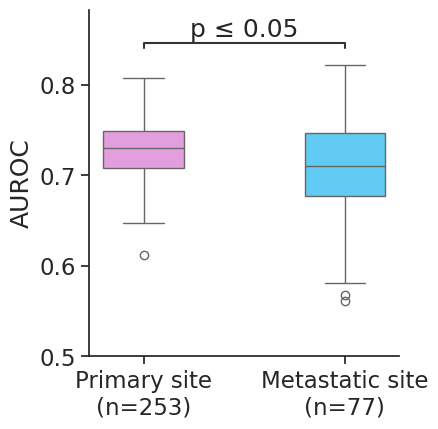

In [175]:
# fig, ax = plt.subplots(figsize=(16, 8))
# sns.boxplot(data=dfr, x = 'Biopsy_site', y = 'PRC', ax=ax) #, ax=ax

In [113]:
data = df_label[df_label.cohort == 'IMVigor210']
#data = df_label[df_label.cancer_type == 'SKCM']
data = data[~data.Biopsy_site.isna()]
data['tissue_type'] = data.Biopsy_site.isin(BLCA_primary_tissues).map({True:'primary', 
                                                                       False:'metastatic'})

In [114]:
dfr = data.groupby('Biopsy_site').parallel_apply(bootstrap_score)

In [115]:
dfr.columns = ['ROC', 'PRC', 'F1', 'ACC','MCC']
dfr = dfr.reset_index()
dfr = dfr.rename(columns = {'level_1':'bootstrap'})

<Axes: xlabel='Biopsy_site', ylabel='ROC'>

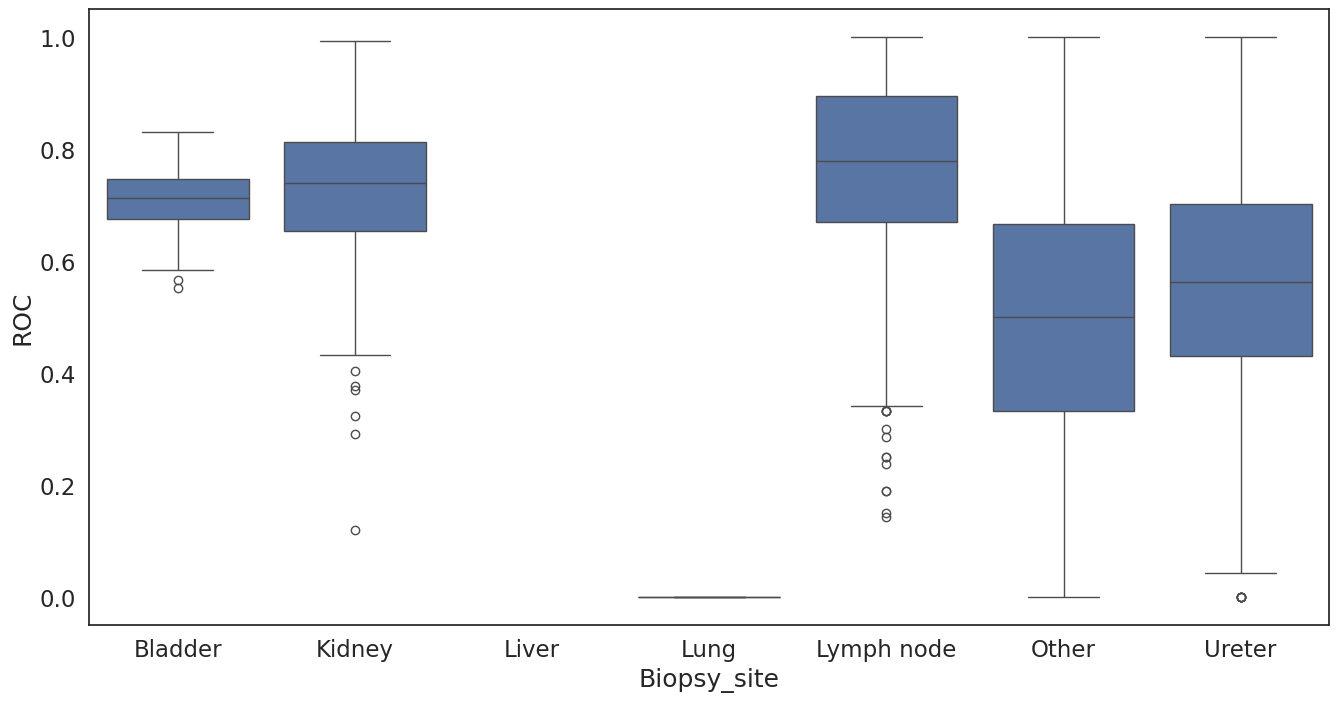

In [116]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(data=dfr, x = 'Biopsy_site', y = 'ROC', ax=ax) #, ax=ax

<Axes: xlabel='Biopsy_site', ylabel='PRC'>

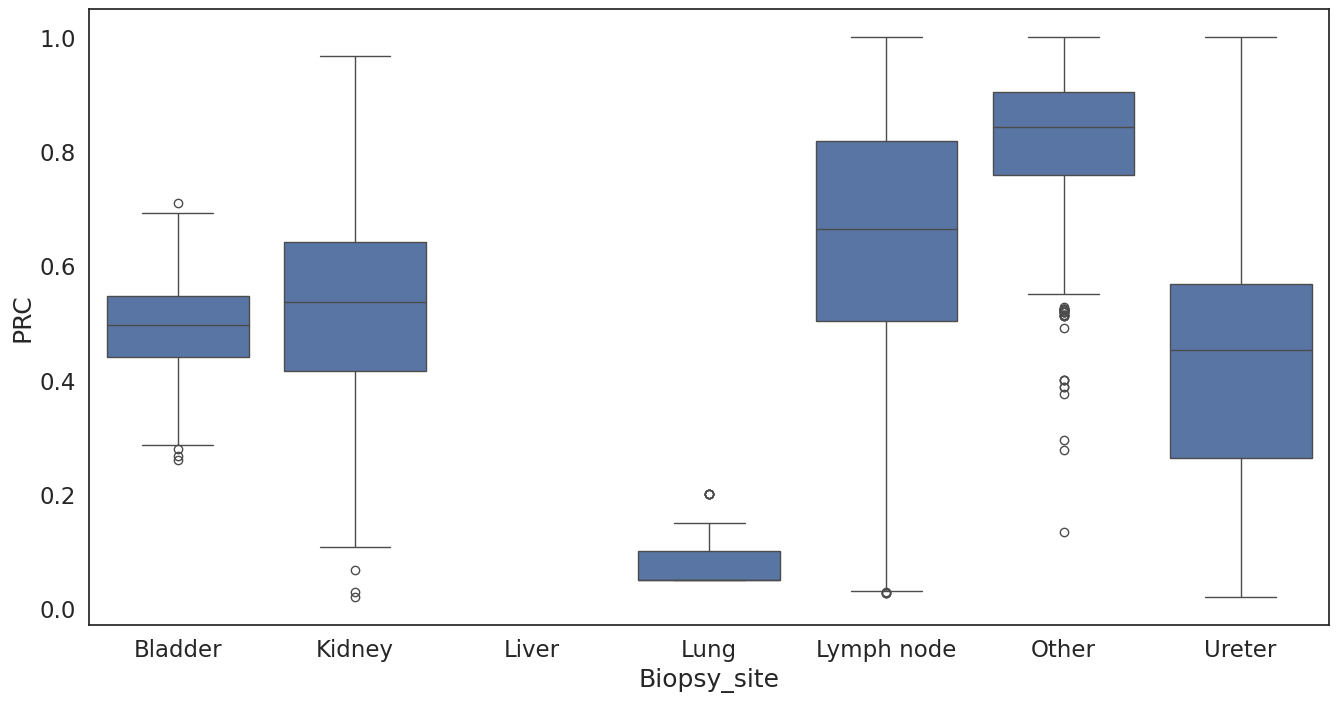

In [117]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(data=dfr, x = 'Biopsy_site', y = 'PRC', ax=ax) #, ax=ax